In [1]:
!git clone https://github.com/januar-png/earlystop.git

Cloning into 'earlystop'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 68 (delta 35), reused 17 (delta 7), pack-reused 0
Receiving objects: 100% (68/68), 7.27 MiB | 13.32 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [2]:
from earlystop import Earlystop

In [3]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
batch_size = 32
img_size = 224

train_transform = transforms.Compose([
    transforms.RandomVerticalFlip(), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(7),
    transforms.Resize(size=(img_size)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/kaggle/input/rice-desease/datapadi/train', transform = train_transform)
trainloader = DataLoader(train_set, batch_size, shuffle = True)

val_set = datasets.ImageFolder('/kaggle/input/rice-desease/datapadi/validation', transform = val_transform)
valloader = DataLoader(val_set, batch_size, shuffle = False)

In [6]:
feature, label = next(iter(valloader))
print(feature.shape)

torch.Size([32, 3, 224, 224])


In [7]:
def ConvBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [32]:
class CNNpenyakitPadi(nn.Module):
    def __init__(self, output_size):
        super(CNNpenyakitPadi, self).__init__()
        self.feature = nn.Sequential(

            ConvBlock(3, 32),
            nn.MaxPool2d(2,2),
            
            ConvBlock(32, 64),
            nn.MaxPool2d(2,2),
            
            ConvBlock(64, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 512),
            nn.MaxPool2d(2,2),

        
        )
        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(512*7*7,256),
            nn.ReLU(),
            nn.Linear(256, output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [33]:
from tqdm import tqdm

In [34]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item()
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataloader)
    acc = correct / len(dataset)
    return cost, acc


def fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, early_stop, epochs):
    for epoch in range(epochs):
        train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

        early_stop.log(train_cost, test_cost, train_score, test_score)

        if early_stop.early_stopping(model, monitor="test_cost") or epoch >= epochs - 1:
            early_stop.plot_cost()
            early_stop.plot_score()
            break

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-7)
early_stop = Earlystop(model, outdir="model", early_stop_patience=2)
epoch = 100

Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 1: train_loss=1.7887, val_loss=1.7874, train_score=0.1863, val_score=0.1875


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 2: train_loss=1.7838, val_loss=1.7818, train_score=0.2048, val_score=0.1970


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 3: train_loss=1.7780, val_loss=1.7772, train_score=0.2130, val_score=0.2140


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 4: train_loss=1.7733, val_loss=1.7719, train_score=0.2489, val_score=0.2633


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 5: train_loss=1.7683, val_loss=1.7660, train_score=0.2881, val_score=0.3125


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 6: train_loss=1.7620, val_loss=1.7612, train_score=0.3562, val_score=0.3655


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 7: train_loss=1.7557, val_loss=1.7547, train_score=0.3883, val_score=0.4148


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 8: train_loss=1.7489, val_loss=1.7492, train_score=0.4243, val_score=0.4527


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 9: train_loss=1.7419, val_loss=1.7416, train_score=0.4434, val_score=0.4659


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 10: train_loss=1.7352, val_loss=1.7350, train_score=0.4662, val_score=0.4773


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 11: train_loss=1.7259, val_loss=1.7269, train_score=0.4755, val_score=0.4811


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 12: train_loss=1.7189, val_loss=1.7190, train_score=0.4918, val_score=0.4773


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 13: train_loss=1.7116, val_loss=1.7103, train_score=0.4956, val_score=0.4773


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 14: train_loss=1.7014, val_loss=1.7021, train_score=0.4967, val_score=0.4792


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 15: train_loss=1.6949, val_loss=1.6941, train_score=0.5082, val_score=0.4811


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 16: train_loss=1.6841, val_loss=1.6853, train_score=0.5185, val_score=0.4830


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 17: train_loss=1.6766, val_loss=1.6767, train_score=0.5180, val_score=0.4848


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 18: train_loss=1.6687, val_loss=1.6693, train_score=0.5403, val_score=0.5057


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 19: train_loss=1.6609, val_loss=1.6613, train_score=0.5430, val_score=0.5265


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 20: train_loss=1.6535, val_loss=1.6531, train_score=0.5512, val_score=0.5322


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 21: train_loss=1.6444, val_loss=1.6465, train_score=0.5714, val_score=0.5682


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 22: train_loss=1.6370, val_loss=1.6392, train_score=0.5735, val_score=0.5777


Test: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 23: train_loss=1.6295, val_loss=1.6331, train_score=0.5708, val_score=0.5814


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 24: train_loss=1.6210, val_loss=1.6238, train_score=0.5926, val_score=0.5833


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 25: train_loss=1.6147, val_loss=1.6163, train_score=0.5795, val_score=0.5890


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 26: train_loss=1.6091, val_loss=1.6084, train_score=0.5948, val_score=0.5890


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 27: train_loss=1.6022, val_loss=1.6034, train_score=0.5959, val_score=0.5890


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 28: train_loss=1.5916, val_loss=1.5979, train_score=0.5986, val_score=0.6004


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 29: train_loss=1.5859, val_loss=1.5900, train_score=0.6122, val_score=0.6061


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 30: train_loss=1.5796, val_loss=1.5837, train_score=0.6111, val_score=0.6080


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 31: train_loss=1.5744, val_loss=1.5790, train_score=0.6149, val_score=0.6136


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 32: train_loss=1.5673, val_loss=1.5705, train_score=0.6160, val_score=0.6174


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 33: train_loss=1.5598, val_loss=1.5670, train_score=0.6187, val_score=0.6155


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 34: train_loss=1.5553, val_loss=1.5608, train_score=0.6209, val_score=0.6193


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 35: train_loss=1.5491, val_loss=1.5562, train_score=0.6247, val_score=0.6212


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 36: train_loss=1.5454, val_loss=1.5501, train_score=0.6296, val_score=0.6193


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 37: train_loss=1.5390, val_loss=1.5449, train_score=0.6302, val_score=0.6193


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 38: train_loss=1.5361, val_loss=1.5386, train_score=0.6247, val_score=0.6212


Test: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 39: train_loss=1.5292, val_loss=1.5359, train_score=0.6285, val_score=0.6250


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 40: train_loss=1.5275, val_loss=1.5315, train_score=0.6334, val_score=0.6250


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 41: train_loss=1.5185, val_loss=1.5276, train_score=0.6324, val_score=0.6231


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 42: train_loss=1.5159, val_loss=1.5207, train_score=0.6351, val_score=0.6288


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 43: train_loss=1.5130, val_loss=1.5187, train_score=0.6324, val_score=0.6288


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 45: train_loss=1.5045, val_loss=1.5105, train_score=0.6373, val_score=0.6307


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 46: train_loss=1.5005, val_loss=1.5069, train_score=0.6405, val_score=0.6345


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 47: train_loss=1.4960, val_loss=1.5033, train_score=0.6405, val_score=0.6345


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 48: train_loss=1.4953, val_loss=1.5011, train_score=0.6400, val_score=0.6326


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 49: train_loss=1.4912, val_loss=1.4968, train_score=0.6427, val_score=0.6364


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 50: train_loss=1.4880, val_loss=1.4949, train_score=0.6443, val_score=0.6345


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 51: train_loss=1.4856, val_loss=1.4904, train_score=0.6389, val_score=0.6364


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 52: train_loss=1.4815, val_loss=1.4864, train_score=0.6405, val_score=0.6402


Test: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 53: train_loss=1.4770, val_loss=1.4849, train_score=0.6449, val_score=0.6326


Test: 100%|██████████| 17/17 [00:15<00:00,  1.08it/s]


Epoch 54: train_loss=1.4758, val_loss=1.4820, train_score=0.6498, val_score=0.6402


Test: 100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


Epoch 55: train_loss=1.4735, val_loss=1.4797, train_score=0.6460, val_score=0.6364


Test: 100%|██████████| 17/17 [00:14<00:00,  1.20it/s]


Epoch 56: train_loss=1.4676, val_loss=1.4757, train_score=0.6481, val_score=0.6402


Test: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


Epoch 57: train_loss=1.4686, val_loss=1.4721, train_score=0.6443, val_score=0.6458


Test: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 58: train_loss=1.4666, val_loss=1.4691, train_score=0.6476, val_score=0.6458


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 59: train_loss=1.4642, val_loss=1.4684, train_score=0.6541, val_score=0.6458


Test: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 60: train_loss=1.4613, val_loss=1.4647, train_score=0.6531, val_score=0.6496


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 61: train_loss=1.4595, val_loss=1.4654, train_score=0.6574, val_score=0.6534
EarlyStop patience =  1. Best test_cost: 1.4647


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 62: train_loss=1.4571, val_loss=1.4605, train_score=0.6531, val_score=0.6515


Test: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 63: train_loss=1.4521, val_loss=1.4567, train_score=0.6552, val_score=0.6515


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 64: train_loss=1.4513, val_loss=1.4553, train_score=0.6558, val_score=0.6515


Test: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 65: train_loss=1.4475, val_loss=1.4528, train_score=0.6541, val_score=0.6515


Test: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch 66: train_loss=1.4460, val_loss=1.4492, train_score=0.6590, val_score=0.6572


Test: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 67: train_loss=1.4466, val_loss=1.4486, train_score=0.6585, val_score=0.6572


Test: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 68: train_loss=1.4445, val_loss=1.4476, train_score=0.6536, val_score=0.6515


Test: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch 69: train_loss=1.4432, val_loss=1.4435, train_score=0.6590, val_score=0.6591


Test: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 70: train_loss=1.4383, val_loss=1.4420, train_score=0.6580, val_score=0.6629


Test: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 71: train_loss=1.4366, val_loss=1.4402, train_score=0.6574, val_score=0.6610


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 72: train_loss=1.4355, val_loss=1.4383, train_score=0.6607, val_score=0.6686


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 73: train_loss=1.4317, val_loss=1.4359, train_score=0.6639, val_score=0.6686


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 74: train_loss=1.4312, val_loss=1.4351, train_score=0.6629, val_score=0.6629


Test: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 75: train_loss=1.4312, val_loss=1.4322, train_score=0.6601, val_score=0.6686


Test: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]


Epoch 76: train_loss=1.4279, val_loss=1.4307, train_score=0.6667, val_score=0.6723


Test: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 77: train_loss=1.4258, val_loss=1.4302, train_score=0.6650, val_score=0.6648


Test: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 78: train_loss=1.4255, val_loss=1.4275, train_score=0.6672, val_score=0.6723


Test: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


Epoch 79: train_loss=1.4232, val_loss=1.4256, train_score=0.6650, val_score=0.6723


Test: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch 80: train_loss=1.4221, val_loss=1.4244, train_score=0.6699, val_score=0.6761


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 81: train_loss=1.4227, val_loss=1.4237, train_score=0.6656, val_score=0.6761


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 82: train_loss=1.4170, val_loss=1.4207, train_score=0.6683, val_score=0.6742


Test: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 83: train_loss=1.4170, val_loss=1.4191, train_score=0.6683, val_score=0.6799


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 84: train_loss=1.4143, val_loss=1.4164, train_score=0.6721, val_score=0.6799


Test: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch 85: train_loss=1.4136, val_loss=1.4150, train_score=0.6683, val_score=0.6780


Test: 100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


Epoch 86: train_loss=1.4117, val_loss=1.4138, train_score=0.6699, val_score=0.6761


Test: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 87: train_loss=1.4141, val_loss=1.4119, train_score=0.6710, val_score=0.6780


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 88: train_loss=1.4086, val_loss=1.4113, train_score=0.6732, val_score=0.6818


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 89: train_loss=1.4067, val_loss=1.4108, train_score=0.6748, val_score=0.6818


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 90: train_loss=1.4074, val_loss=1.4096, train_score=0.6759, val_score=0.6856


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 91: train_loss=1.4068, val_loss=1.4068, train_score=0.6770, val_score=0.6799


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 92: train_loss=1.4046, val_loss=1.4053, train_score=0.6727, val_score=0.6818


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 93: train_loss=1.4015, val_loss=1.4047, train_score=0.6803, val_score=0.6856


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 94: train_loss=1.4045, val_loss=1.4025, train_score=0.6770, val_score=0.6837


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 95: train_loss=1.4027, val_loss=1.4025, train_score=0.6754, val_score=0.6875


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 96: train_loss=1.4011, val_loss=1.4009, train_score=0.6825, val_score=0.6875


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 97: train_loss=1.3992, val_loss=1.3987, train_score=0.6825, val_score=0.6837


Test: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 98: train_loss=1.3960, val_loss=1.3974, train_score=0.6814, val_score=0.6875


Test: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 99: train_loss=1.3967, val_loss=1.3983, train_score=0.6814, val_score=0.6894
EarlyStop patience =  1. Best test_cost: 1.3974


Test: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Epoch 100: train_loss=1.3945, val_loss=1.3957, train_score=0.6808, val_score=0.6875


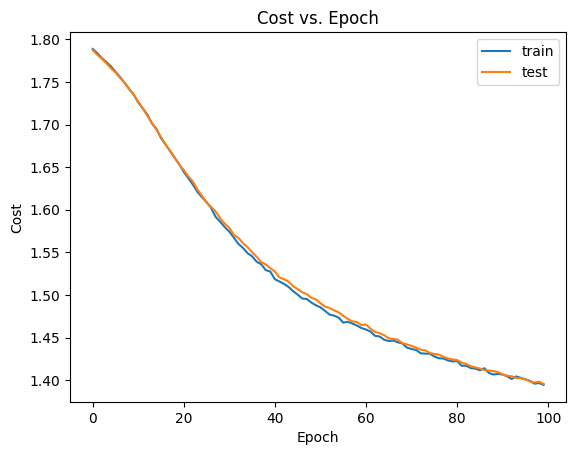

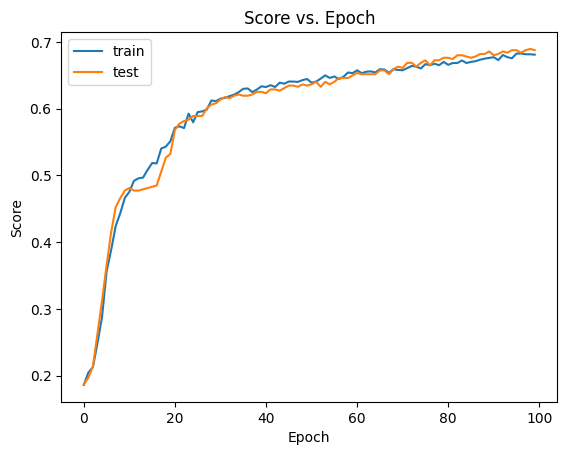

In [40]:
fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, early_stop, epoch)

In [24]:
!pip install torchsummary

In [48]:
test_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])
test_set = datasets.ImageFolder('/kaggle/input/rice-desease/datapadi/test', transform=test_transform)
testloader = DataLoader(test_set, shuffle=False)

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [50]:
def evaluate_model(model, testloader, criterion, device):
    model.load_state_dict(torch.load('/kaggle/working/model/best_model.pth'))
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    average_loss = total_loss / len(testloader)
    accuracy = sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)
    
    class_counts_labels = np.bincount(all_labels)
    class_counts_predictions = np.bincount(all_predictions)

    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_set.classes, yticklabels=test_set.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Test Loss: 1.3644, Test Accuracy: 0.7576
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.87      0.77      0.82        44
           2       0.53      0.95      0.68        44
           3       0.00      0.00      0.00        44
           4       0.95      0.91      0.93        44
           5       0.70      0.95      0.81        44

    accuracy                           0.76       264
   macro avg       0.67      0.76      0.70       264
weighted avg       0.67      0.76      0.70       264

Confusion Matrix:


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


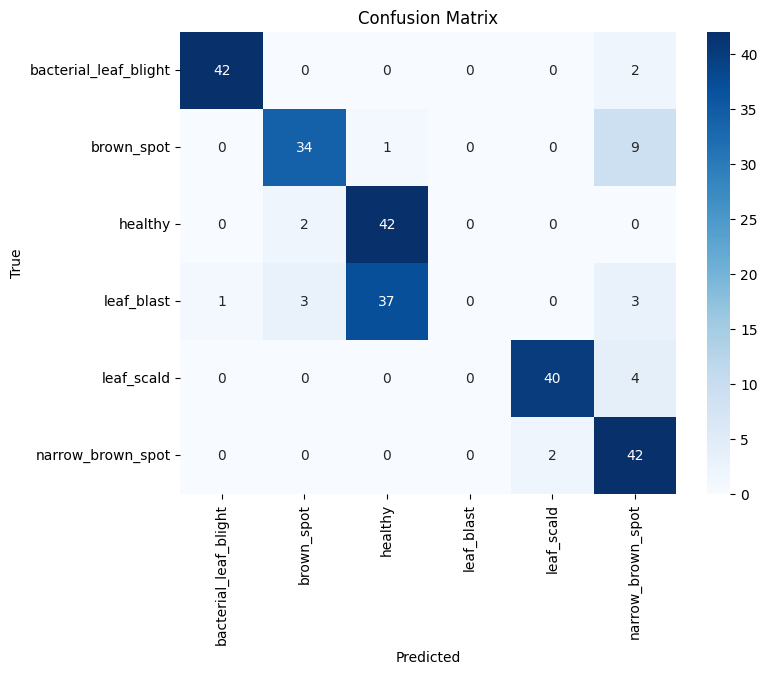

In [51]:
evaluate_model(model, testloader, criterion, device)

In [52]:
from torchsummary import summary

model = CNNpenyakitPadi(output_size = 6).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]         147,584
      BatchNorm2d-14          [-1, 128,

In [56]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


activation1 = {}
jumlah = 100

def get_activation(name):
    def hook(module, input, output):
        activation1[name] = output.detach()
    return hook

model.feature[0][0].register_forward_hook(get_activation('conv'))
model.feature[2][0].register_forward_hook(get_activation('conv2'))
model.feature[4][0].register_forward_hook(get_activation('conv4'))

model.feature[0][2].register_forward_hook(get_activation('relu'))
model.feature[2][2].register_forward_hook(get_activation('relu3'))
model.feature[4][2].register_forward_hook(get_activation('relu5'))


img = Image.open('/kaggle/input/rice-desease/datapadi/test/brown_spot/brown_spot (320).jpg')
rgb_image = img.convert('RGB')

transform = transforms.Compose([
    transforms.Resize(size=(224)),
    transforms.ToTensor()
])
img_tensor = transform(rgb_image)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.cuda()

output = model(img_tensor)

/tmp/ipykernel_32/3142080358.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


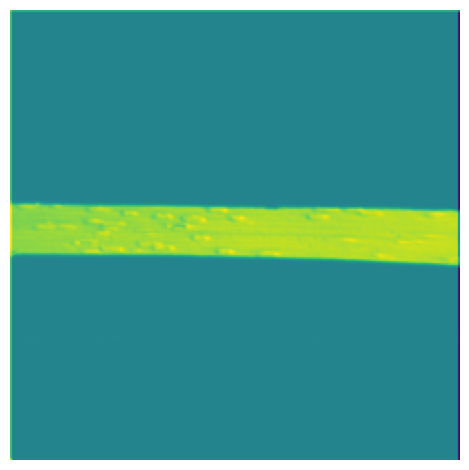

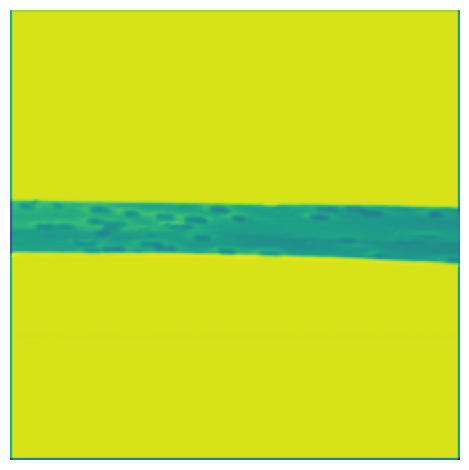

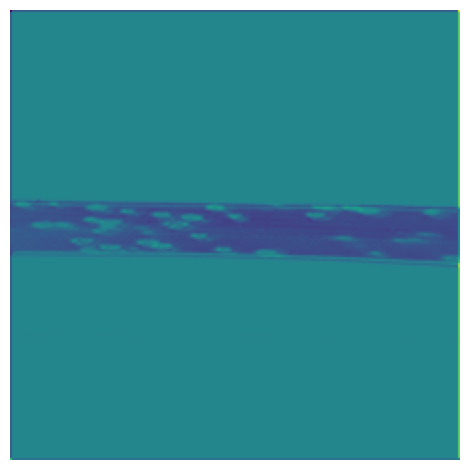

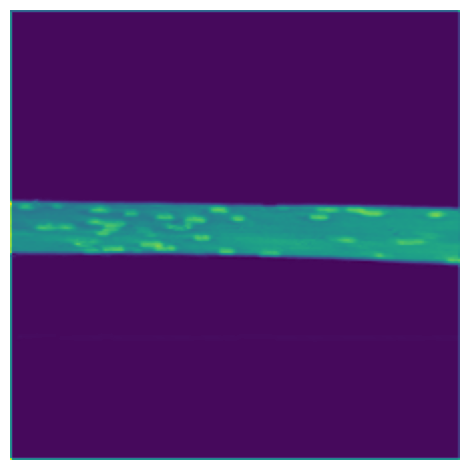

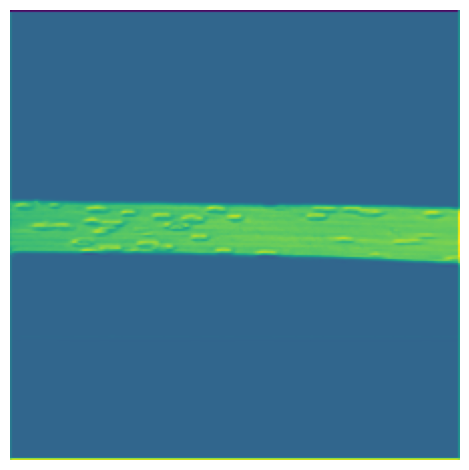

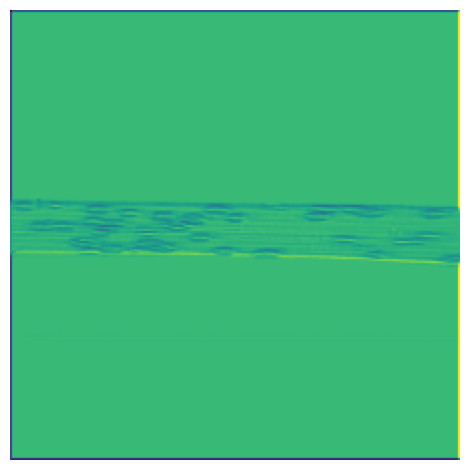

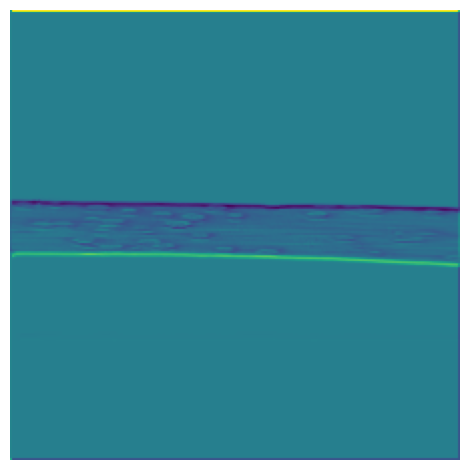

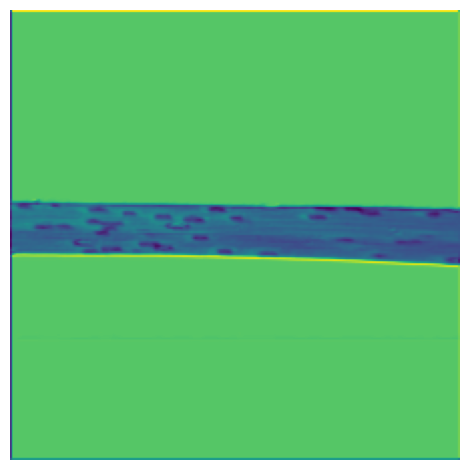

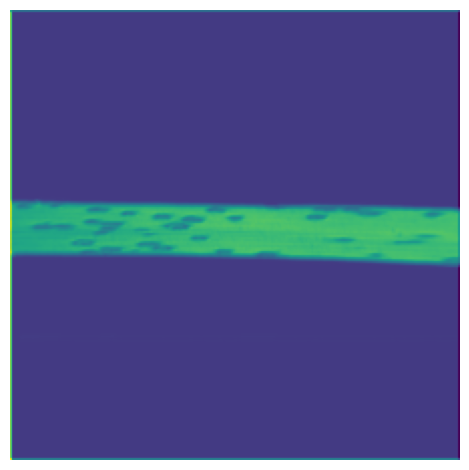

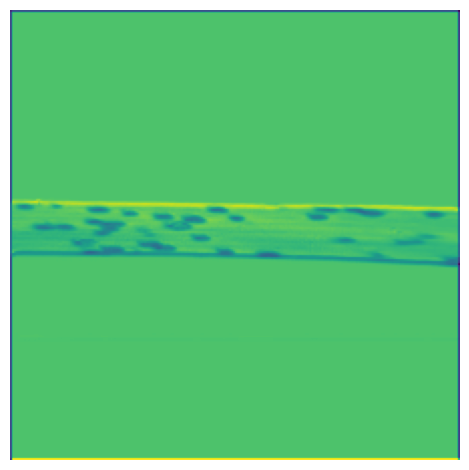

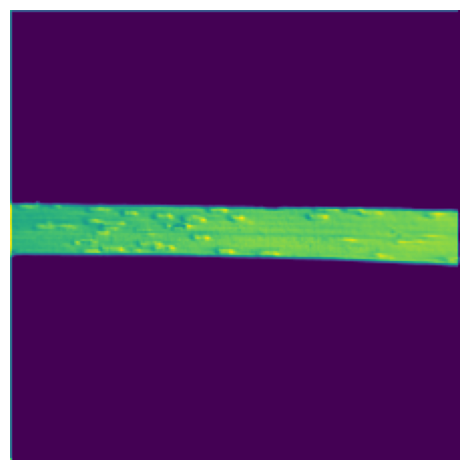

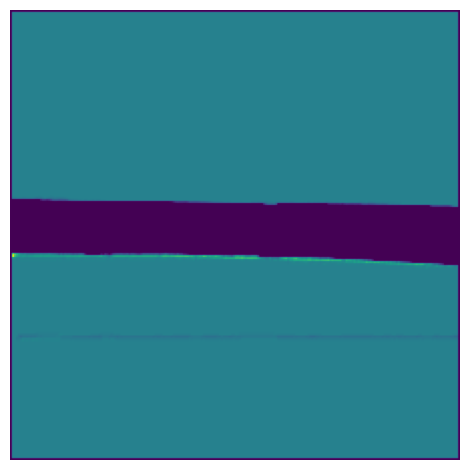

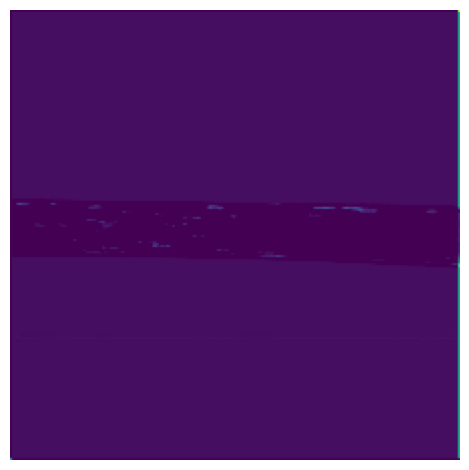

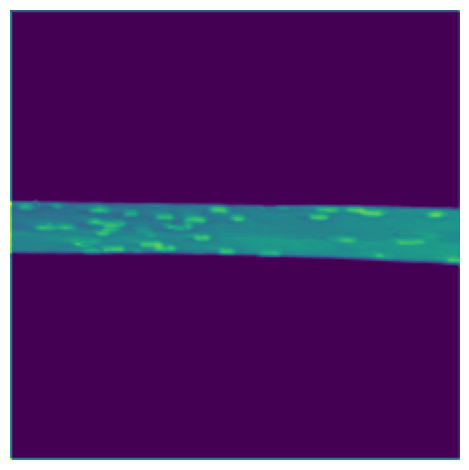

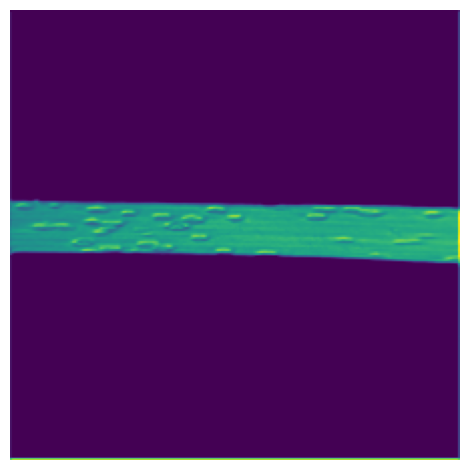

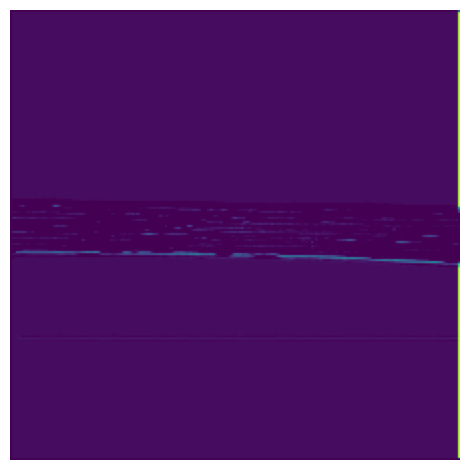

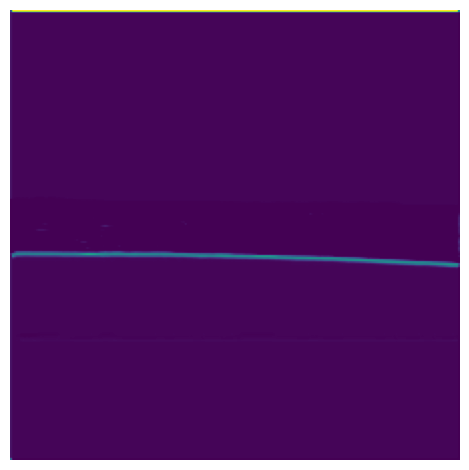

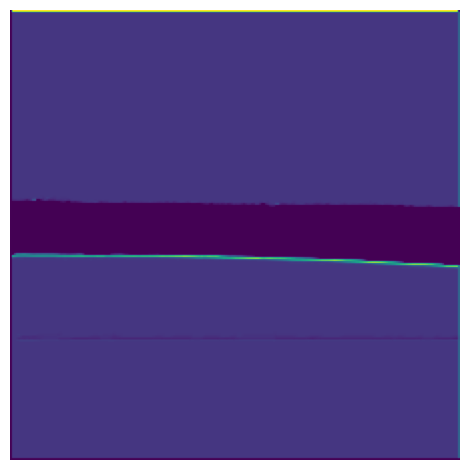

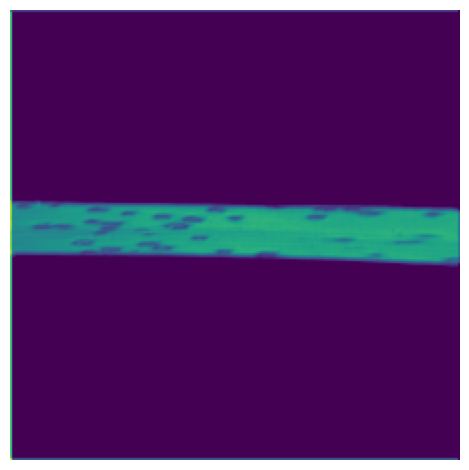

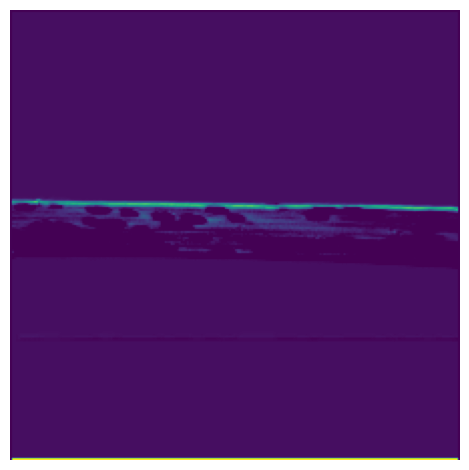

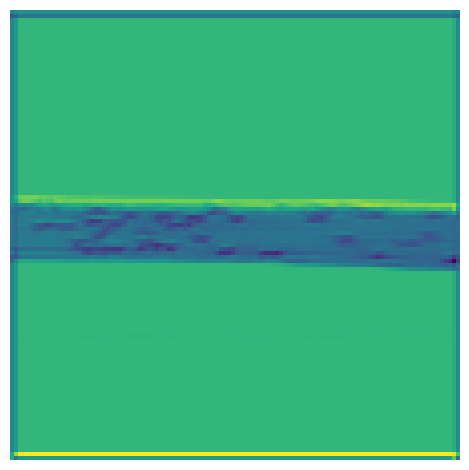

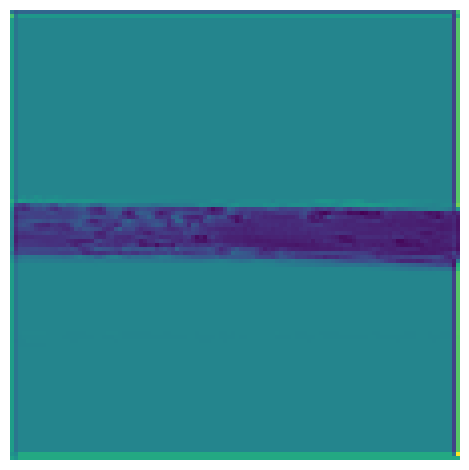

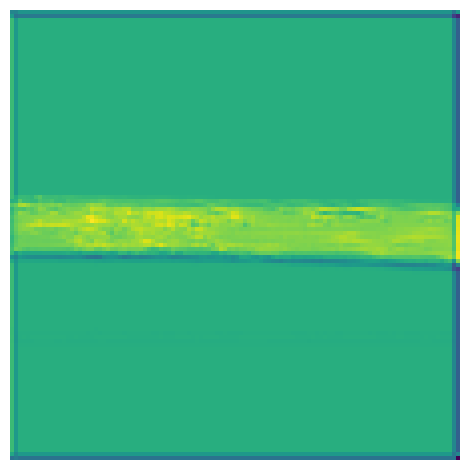

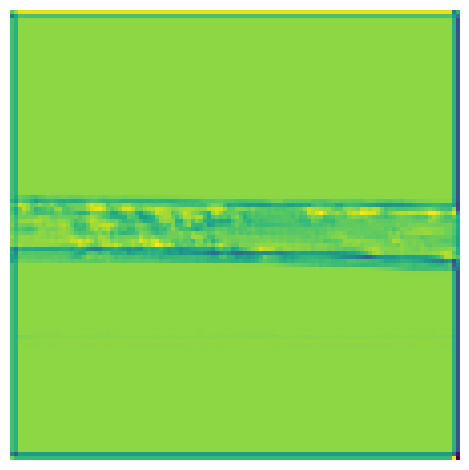

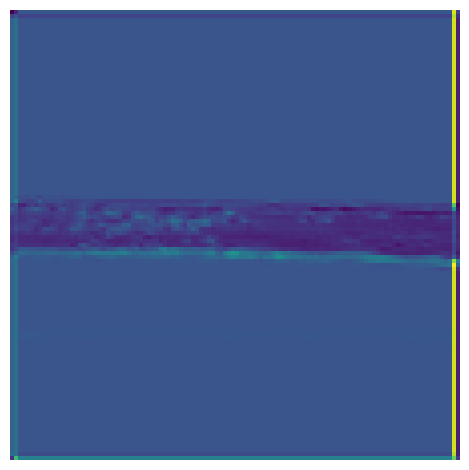

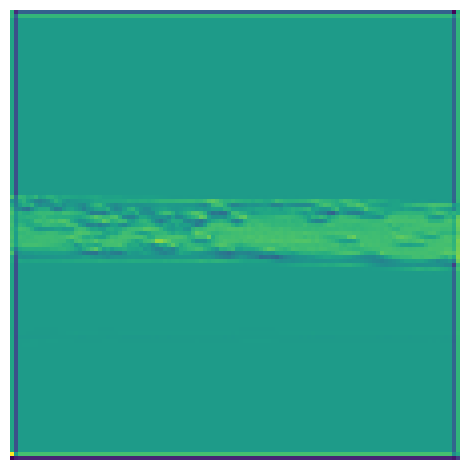

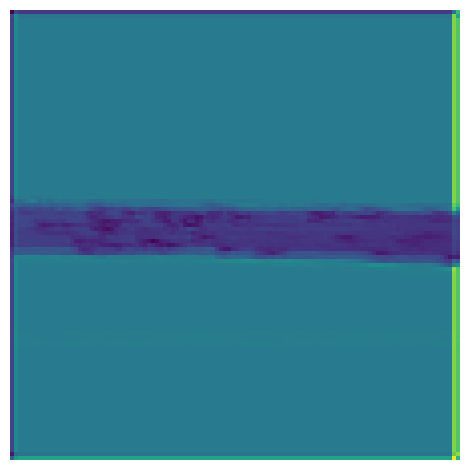

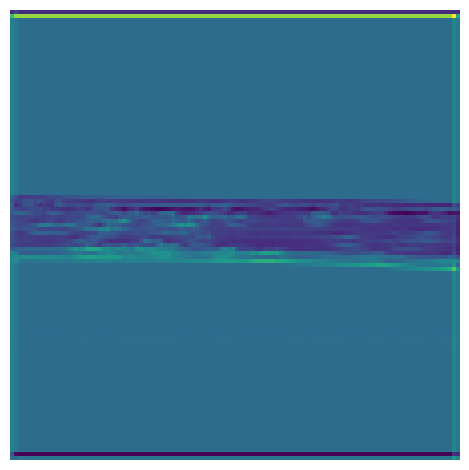

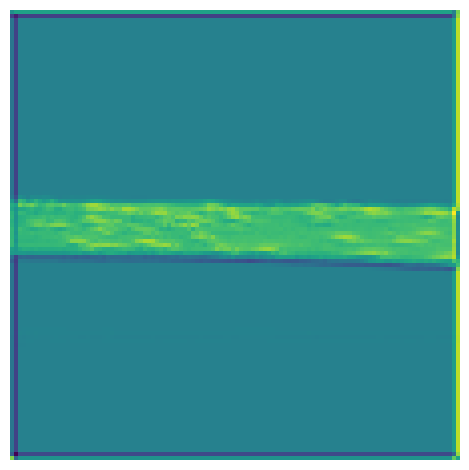

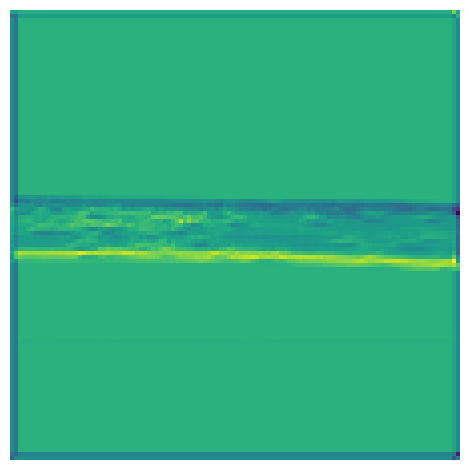

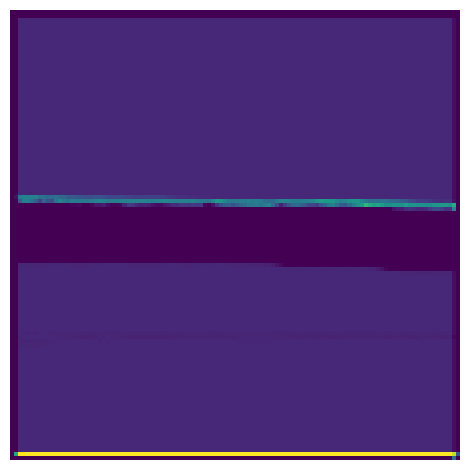

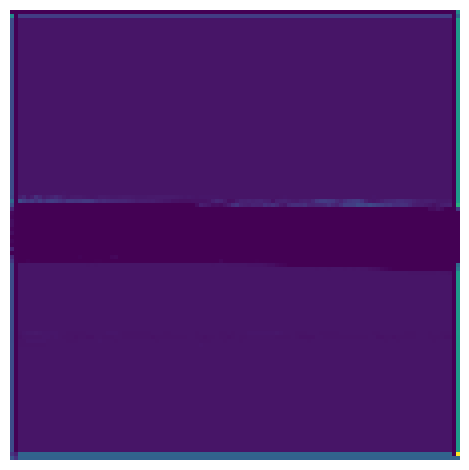

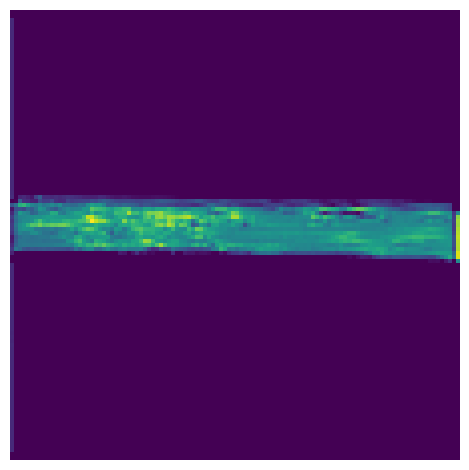

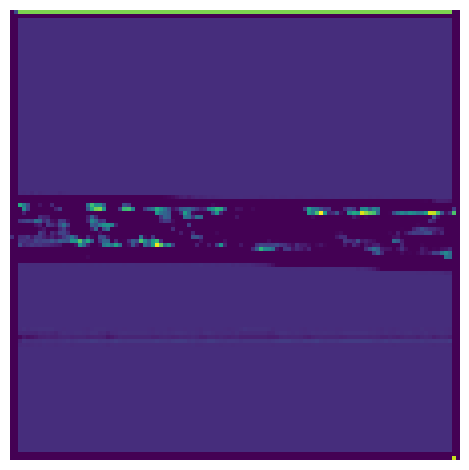

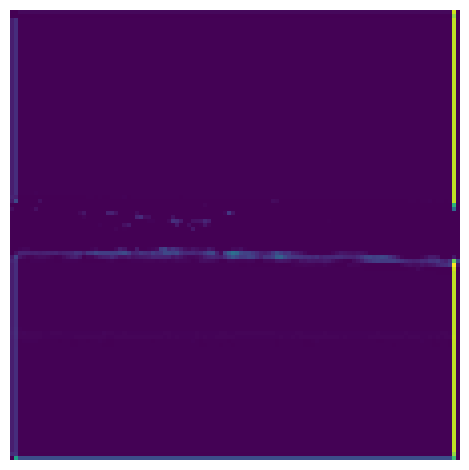

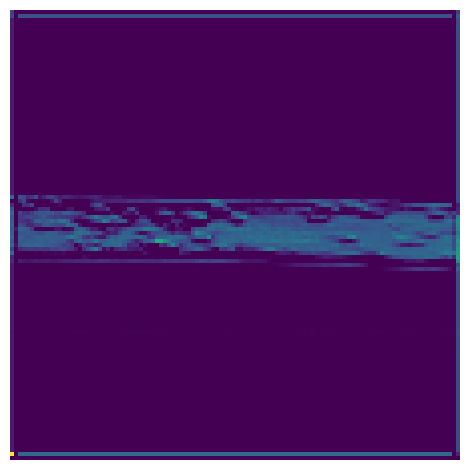

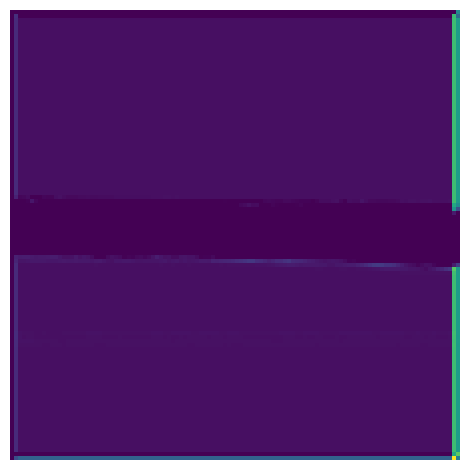

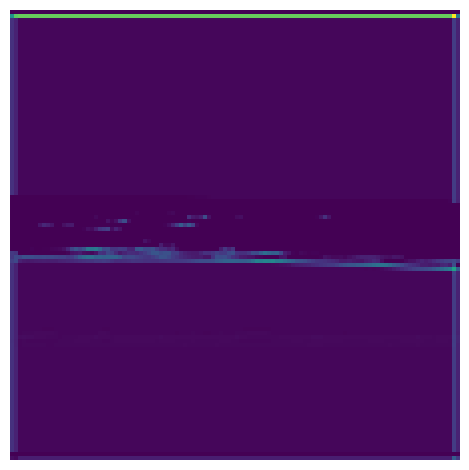

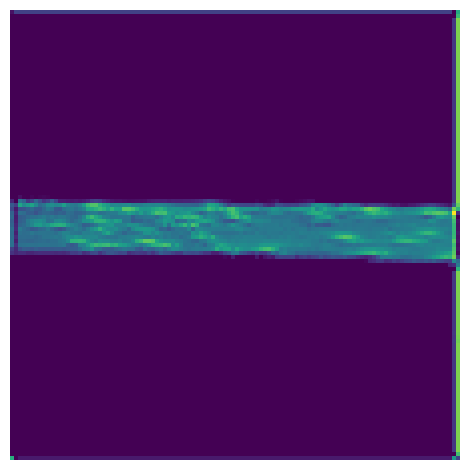

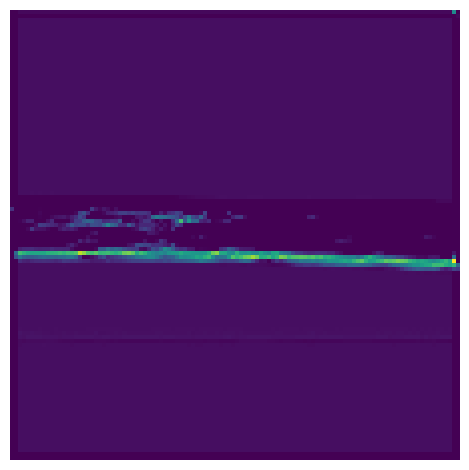

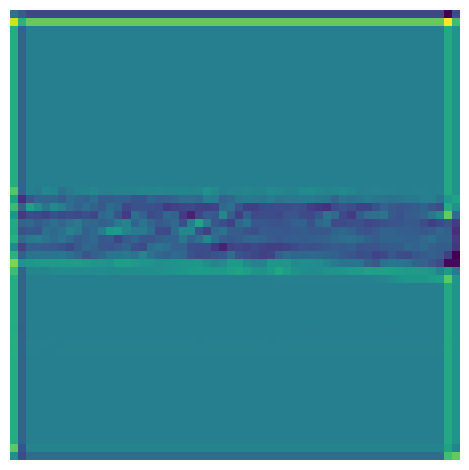

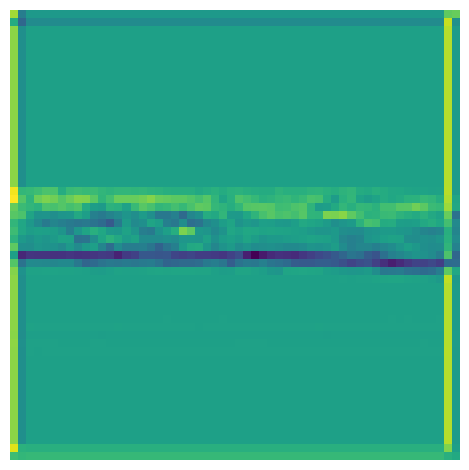

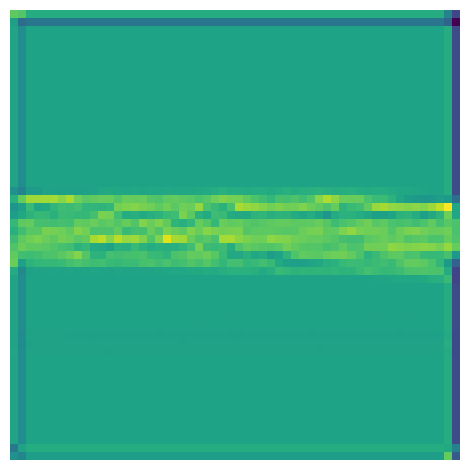

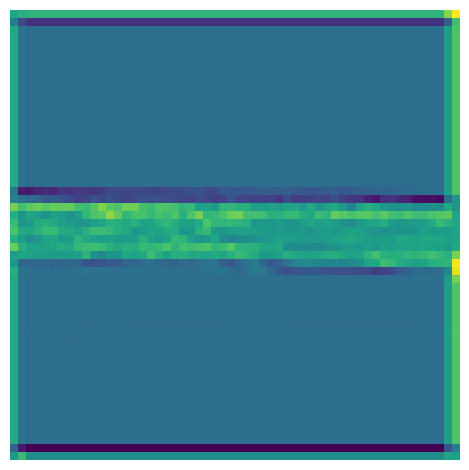

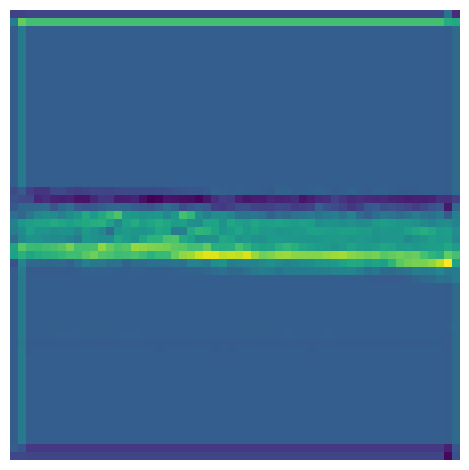

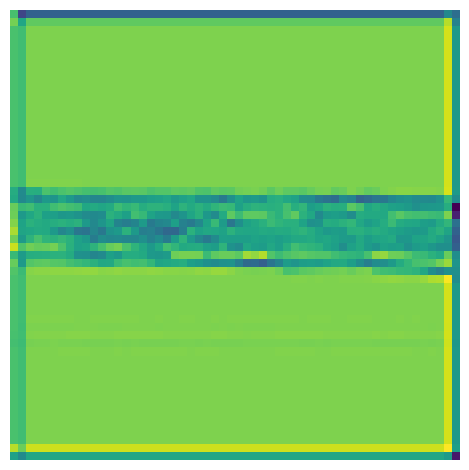

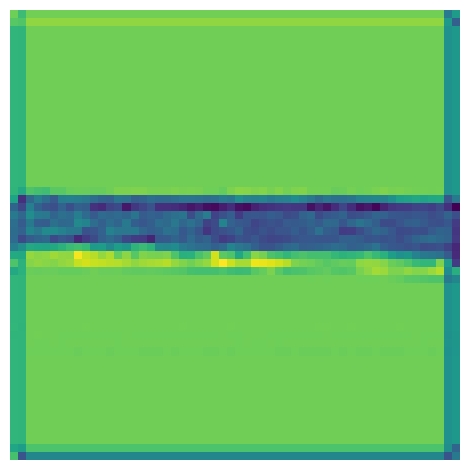

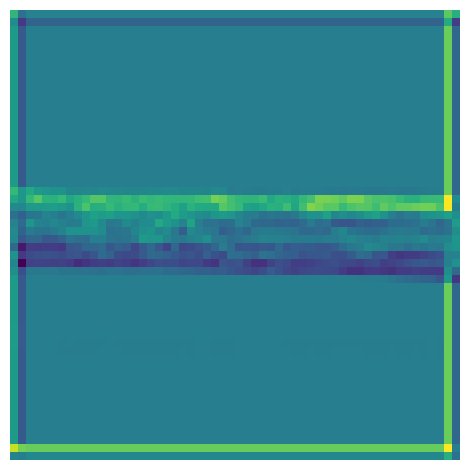

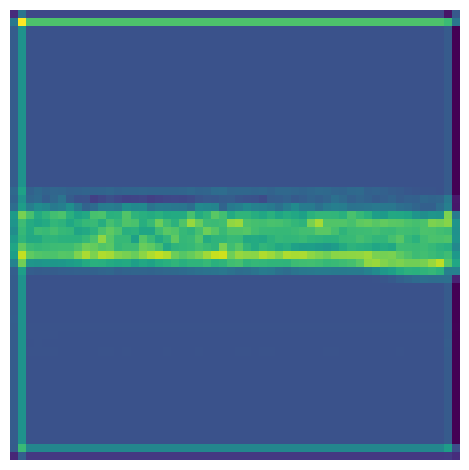

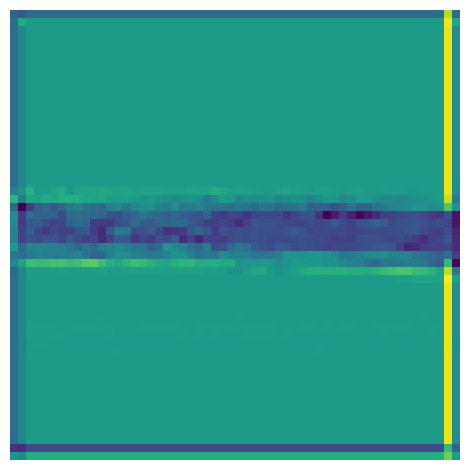

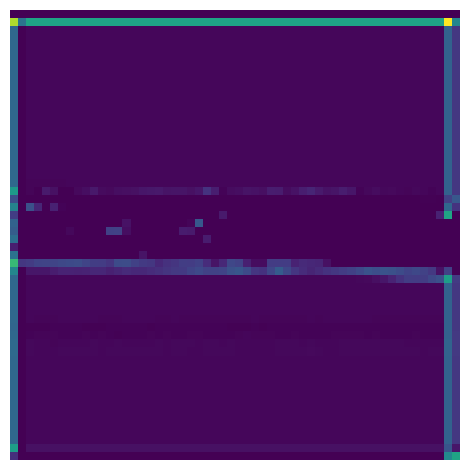

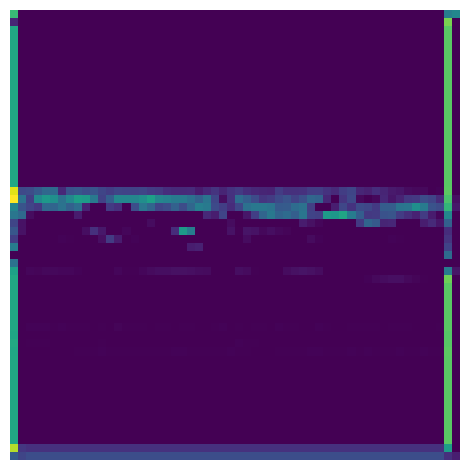

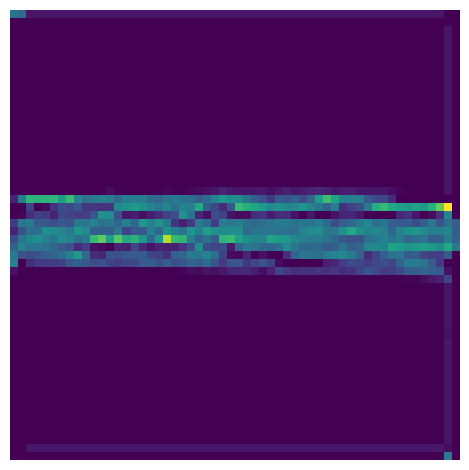

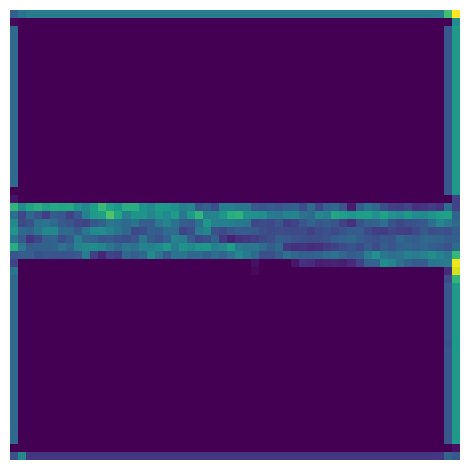

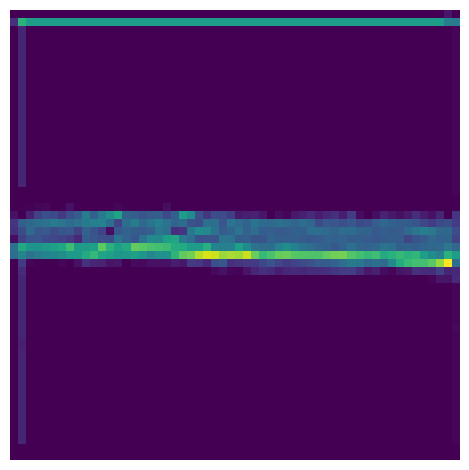

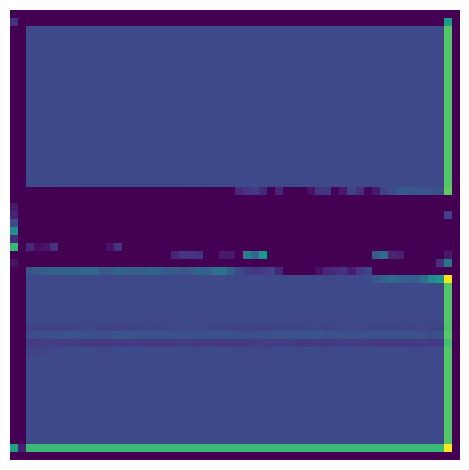

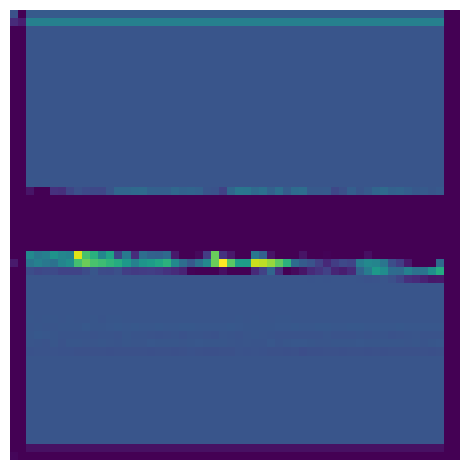

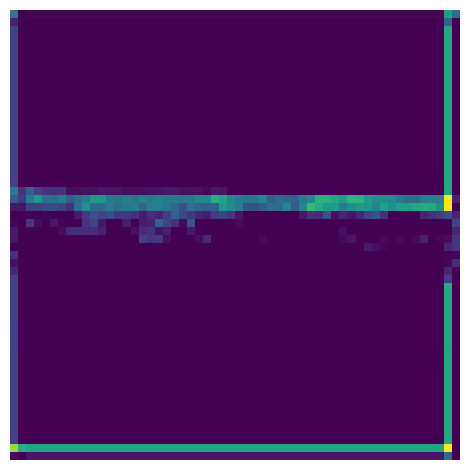

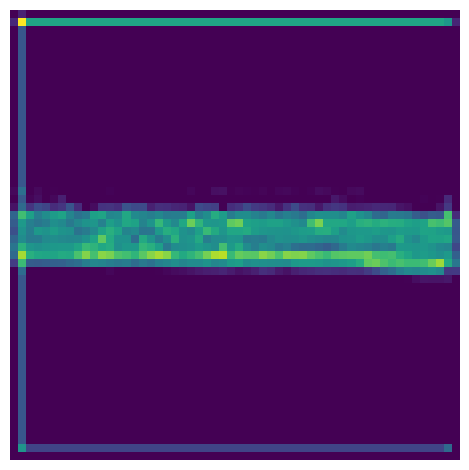

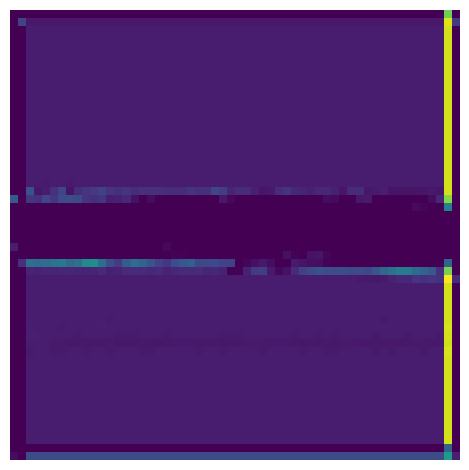

In [57]:
for name in activation1:
    folder_path = os.path.join('custom_11', name)
    file = name

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    if file in activation1:
        num_images = min(max(3, activation1[file].shape[1]), 10)
        for i in range(num_images):
            fig, ax = plt.subplots(1, 1)
            ax.imshow(activation1[file][0, i].cpu().numpy())
            ax.axis('off')
            plt.tight_layout()

            fig.savefig(f'{folder_path}/{file}-{i}.png', dpi=300, transparent=True)


tensor([[[[1.0000, 0.9725, 0.7686, 0.9137, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7373, 0.8941, 1.0000, 1.0000],
          [1.0000, 0.9647, 0.7373, 0.8784, 1.0000, 1.0000],
          [1.0000, 0.9529, 0.7059, 0.8745, 1.0000, 1.0000],
          [1.0000, 0.9451, 0.6941, 0.8392, 0.9922, 1.0000],
          [1.0000, 0.9490, 0.6824, 0.7882, 0.9882, 1.0000]],

         [[1.0000, 0.9647, 0.7098, 0.8902, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7725, 0.8980, 1.0000, 1.0000],
          [1.0000, 0.9608, 0.7529, 0.8706, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.6902, 0.8627, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.7059, 0.8078, 0.9922, 1.0000],
          [1.0000, 0.9451, 0.6588, 0.7843, 0.9843, 1.0000]],

         [[1.0000, 0.9333, 0.4471, 0.7333, 1.0000, 1.0000],
          [1.0000, 0.9294, 0.4235, 0.6902, 1.0000, 1.0000],
          [1.0000, 0.9255, 0.4118, 0.6431, 0.9922, 1.0000],
          [1.0000, 0.9216, 0.3882, 0.6039, 0.9882, 1.0000],
          [1.0000, 0.9176, 0.3608, 0

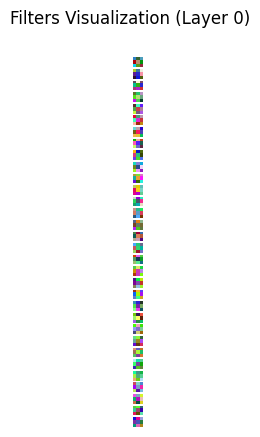

bias :tensor([ 0.1053,  0.0722, -0.1345,  0.0932, -0.1684,  0.0086, -0.1871,  0.0313,
         0.1516,  0.1434, -0.1869,  0.1601,  0.0978,  0.1830, -0.0737,  0.0495,
         0.1185, -0.0518, -0.0451, -0.1186,  0.1902, -0.1278, -0.0947, -0.1513,
         0.0407, -0.1532, -0.1002,  0.0453, -0.0261,  0.0061,  0.0842, -0.0071])


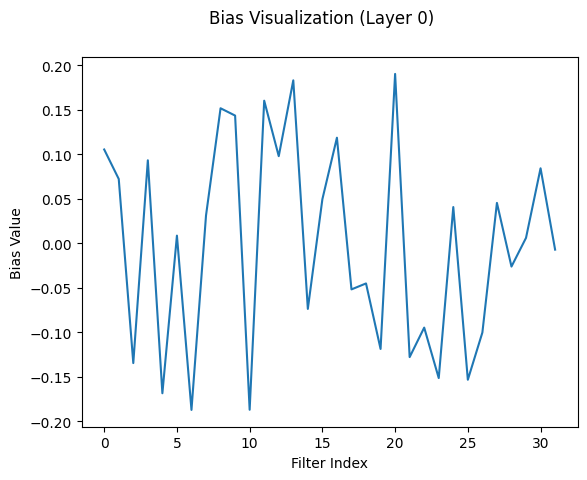

fitur :tensor([[[[-0.4671, -0.4345, -0.4730, -0.5606, -0.6406, -0.1254],
          [-0.6805, -0.6807, -0.6047, -0.7786, -0.8895, -0.4188],
          [-0.6772, -0.6658, -0.5842, -0.7650, -0.8860, -0.4174],
          [-0.6751, -0.6586, -0.5609, -0.7325, -0.8919, -0.4188],
          [-0.6730, -0.6446, -0.5257, -0.7143, -0.8807, -0.4214],
          [-0.3266, -0.5218, -0.4426, -0.4476, -0.5546, -0.3729]],

         [[-0.2751, -0.8212, -0.8093, -0.6990, -0.7855, -0.8443],
          [ 0.1205, -0.5273, -0.4111, -0.2197, -0.2959, -0.8613],
          [ 0.1211, -0.5122, -0.3976, -0.1947, -0.2813, -0.8604],
          [ 0.1170, -0.5170, -0.3883, -0.1812, -0.2568, -0.8568],
          [ 0.1099, -0.5321, -0.3854, -0.1737, -0.2253, -0.8510],
          [ 0.5629,  0.1905,  0.3042,  0.5409,  0.5381, -0.2626]],

         [[-0.5222, -0.5832, -0.5863, -0.6247, -0.6470, -0.3985],
          [-0.1249, -0.3405, -0.4911, -0.3935, -0.3934, -0.0603],
          [-0.1232, -0.3360, -0.4774, -0.3966, -0.3902, -0.0608],

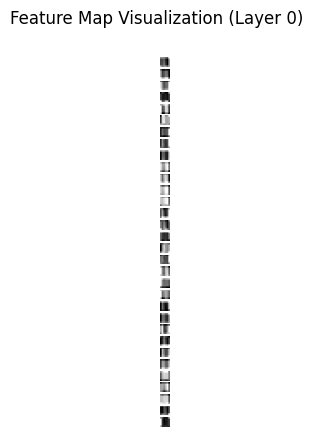

relu :tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.1205, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.1211, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.1170, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.1099, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5629, 0.1905, 0.3042, 0.5409, 0.5381, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0

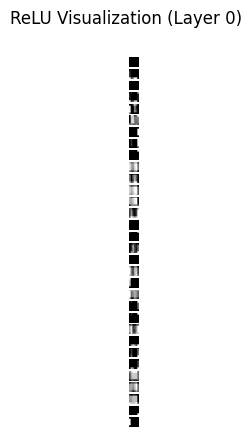

In [58]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def visualize_filters(model, layer_idx):
    layer = model.feature[layer_idx][0]
    filters = layer.weight.data
    filters = filters - filters.min()
    filters = filters / filters.max()

    fig, axs = plt.subplots(filters.size(0))
    fig.suptitle('Filters Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(filter_img.squeeze(), cmap='gray')  
        ax.axis('off')
        print(f"filer :{filter_img}")

    plt.show()
    
def visualize_bias(model, layer_idx):
    layer = model.feature[layer_idx][0]
    bias = layer.bias.data

    fig, ax = plt.subplots()
    fig.suptitle('Bias Visualization (Layer {})'.format(layer_idx))

    ax.plot(bias.cpu().numpy())
    ax.set_xlabel('Filter Index')
    ax.set_ylabel('Bias Value')
    print(f"bias :{bias}")
    plt.show()
    
    

def visualize_feature_maps(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    activations = activations.detach()

    fig, axs = plt.subplots(activations.size(1))
    fig.suptitle('Feature Map Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"fitur :{activations}")

    plt.show()

def visualize_relu(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    relu_activations = torch.relu(activations)
    relu_activations = relu_activations.detach()

    fig, axs = plt.subplots(relu_activations.size(1))
    fig.suptitle('ReLU Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(relu_activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"relu :{relu_activations}")

    plt.show()

output_size = 10  
model = CNNpenyakitPadi(output_size)

transform = transforms.Compose([
    transforms.Resize((6,6)),
    transforms.ToTensor()
])

image_path = '/kaggle/input/rice-desease/datapadi/test/brown_spot/brown_val (50).jpg' 
input_image = Image.open(image_path)
input_image = transform(input_image).unsqueeze(0)


print(input_image)


visualize_filters(model, 0)

visualize_bias(model, 0)

visualize_feature_maps(model, 0, input_image)

visualize_relu(model, 0, input_image)